Decision Tree Model Metrics:
Accuracy: 0.4686
Precision: 0.4668
Recall: 0.4686
F1 Score: 0.4677
AUC: 0.5888

K-NN Model Metrics:
Accuracy: 0.5132
Precision: 0.4749
Recall: 0.5132
F1 Score: 0.4839
AUC: 0.6687


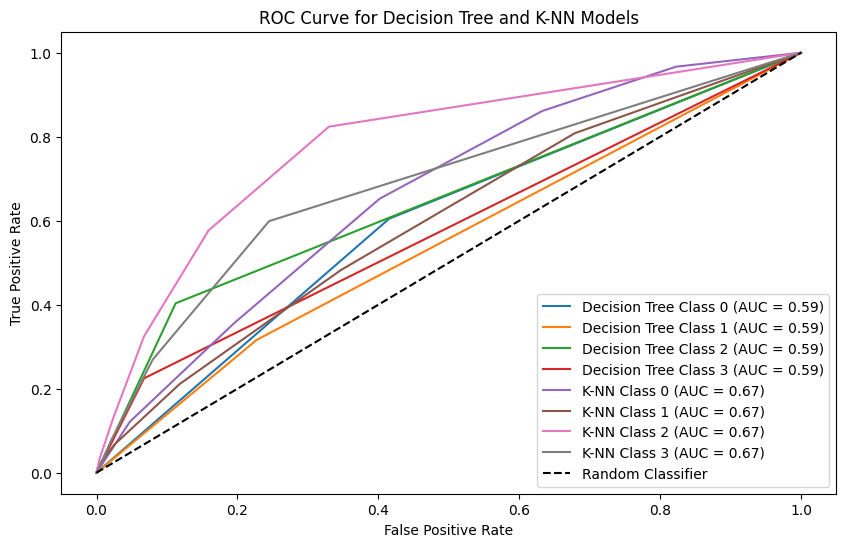

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load dataset
file_path = 'income.csv'  # Update this path if necessary
data = pd.read_csv(file_path)

# Define features (X) and target variable (y)
X = data.drop(columns=['income'])
y = data['income']

# Preprocessing pipeline for categorical and numerical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessing steps for numerical and categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Handle missing values
    ('scaler', StandardScaler())  # Standardize features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical variables
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Encode the target variable for multiclass classification (i.e., income values)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define and train the Decision Tree model
dt_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('dt', DecisionTreeClassifier(random_state=42))])

# Train the Decision Tree model on the encoded target variable
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)

# Define and train the K-NN model
knn_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('knn', KNeighborsClassifier(n_neighbors=5))])

# Train the K-NN model on the encoded target variable
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)

# Calculate metrics for the multiclass classification using the encoded labels
def evaluate_multiclass_model_corrected(y_true, y_pred, model, X_test):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Compute AUC for each class
    y_prob = model.predict_proba(X_test)  # Get probability predictions
    auc = roc_auc_score(y_true, y_prob, multi_class='ovr', average='weighted')

    # ROC curve for each class
    fpr, tpr, thresholds = {}, {}, {}
    for i in range(len(model.classes_)):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_true, y_prob[:, i], pos_label=i)

    return accuracy, precision, recall, f1, auc, fpr, tpr, thresholds

# Now evaluate both models (Decision Tree and K-NN) using the updated metrics
dt_metrics = evaluate_multiclass_model_corrected(
    y_test, dt_predictions, dt_model, X_test)

knn_metrics = evaluate_multiclass_model_corrected(
    y_test, knn_predictions, knn_model, X_test)

# Display the metrics in a clear format for both models
metrics_labels = ["Accuracy", "Precision", "Recall", "F1 Score", "AUC"]

# Print the evaluation metrics for the Decision Tree model
print("Decision Tree Model Metrics:")
for label, value in zip(metrics_labels, dt_metrics[:5]):
    print(f"{label}: {value:.4f}")

# Print the evaluation metrics for the K-NN model
print("\nK-NN Model Metrics:")
for label, value in zip(metrics_labels, knn_metrics[:5]):
    print(f"{label}: {value:.4f}")

# ROC Curve Plot for both models
plt.figure(figsize=(10, 6))

# Plot ROC curve for Decision Tree model
for i in range(len(dt_metrics[5])):
    plt.plot(dt_metrics[5][i], dt_metrics[6][i], label=f'Decision Tree Class {i} (AUC = {dt_metrics[4]:.2f})')

# Plot ROC curve for K-NN model
for i in range(len(knn_metrics[5])):
    plt.plot(knn_metrics[5][i], knn_metrics[6][i], label=f'K-NN Class {i} (AUC = {knn_metrics[4]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree and K-NN Models')
plt.legend(loc='lower right')
plt.show()
